# QR Code

The goal of this homework is to use Fourier transformations as well as denoising and sharpering techniques to recover original image.

We have QR code image, which is distorted to much to read it using phones.

You will try to recover it

In [1]:
# import the necessary modules

import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage import img_as_float

%matplotlib inline

In [2]:
# util function

def show_images(im1, title1, im2, title2, cmap=None):
    
    """
    Shows 2 images with given titles
    :param im1: input image 1
    :param title1: title of the image 1
    :param im2: input image 2
    :param title2: title of the image 2
    :param cmap: colormap of images ('None' by default)
    """
    
    # figure initialization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 35))
    
    # image 1 configuration
    ax1.imshow(im1, cmap=cmap)
    ax1.set_title(title1)
    ax1.set_axis_off()
    
    # image 2 configuration
    ax2.imshow(im2, cmap=cmap)
    ax2.set_title(title2)
    ax2.set_axis_off()

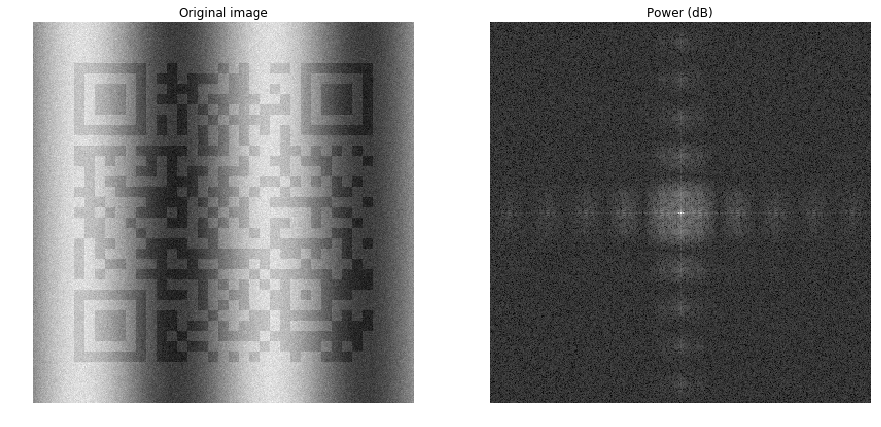

In [3]:
# read QR image
real_img = img_as_float(imread('qr_code.png'))

# DFT (Discrete Fourier Transform) of the image
img_dft = np.fft.fft2(real_img)
# magnitude of FFT (shifted to the center of the spectrum)
mag = np.abs(np.fft.fftshift(img_dft))

# show original image and the power of its spectrum
show_images(real_img, 'Original image', 20*np.log10(mag**2 + 1), 'Power (dB)', cmap='gray')

(1) Note that image distorted with noise. In this case we suggest you to make an assumption that noise consists of gaussian noise and some periodic structure. Using boundaries above QR code plot first line of an image as 1d graph. This is noise we need to deal with.

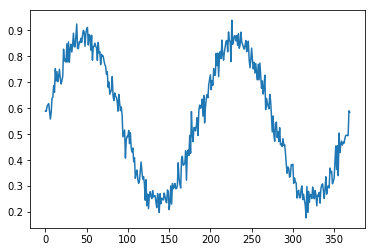

In [4]:
# (1)

LINE_NUM = 0

line = real_img[LINE_NUM]
plt.plot(line)
plt.show()

(2) Substruct it from the image and look if it helps? Replicate first line to fit image size.
Use np.repeat function

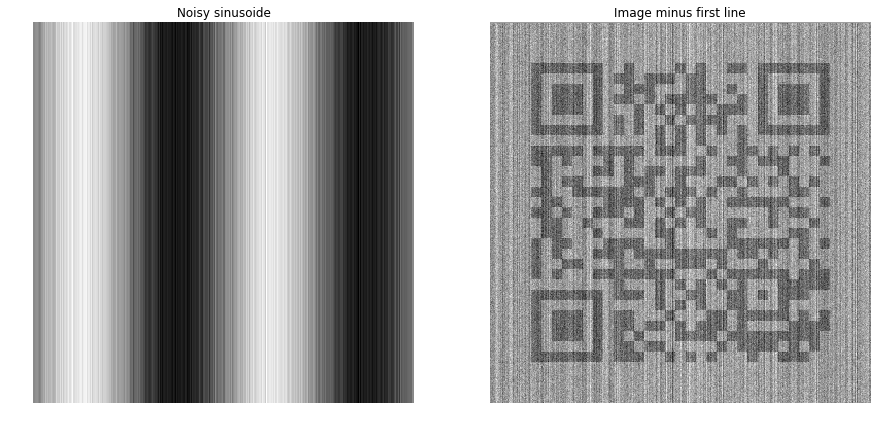

In [5]:
# (2)

show_images(np.repeat([line], len(line), axis=0), 'Noisy sinusoide', real_img - line, 'Image minus first line', cmap='gray')

(3) It should look a bit better, but still too much noise there. It seems that we added more noise by substructing with a noisy sinusoide. Create a sinosuide with same amplitude and frequency. It may be a good idea to look at it in the Fourier domain.

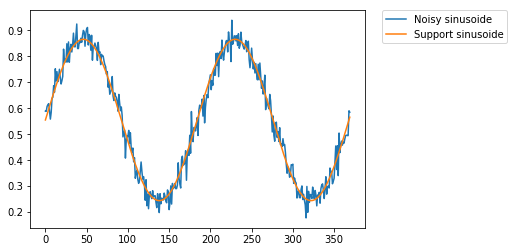

In [6]:
# (3)

# Number of samplepoints
N = len(line)

# sample spacing
T = 1.0 / N

# grid of the sinusoide
x = np.linspace(0, N-1, N)

# fft of the noisy sinusoid
line_f = np.fft.fft(line)

# positive frequencies
freqs = np.linspace(0.0, 1.0/(2.0*T), N/2)

# amplitudes, corresponding to the positive frequencies
ampls = 2.0/N * np.abs(line_f[:N//2])

# coefficient of linear component
lin = ampls[0]

# excluding linear сomponent
freqs = np.delete(freqs, 0)
ampls = np.delete(ampls, 0)

# properties of the support sinusoide
support_freq = freqs[np.argmax(ampls)]
support_ampl = ampls[np.argmax(ampls)]

# support sinusoide
support_sin = support_ampl * np.sin(support_freq*2*np.pi/N * x) + lin/2

# plotting
plt.plot(line, label = 'Noisy sinusoide')
plt.plot(support_sin, label = 'Support sinusoide')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

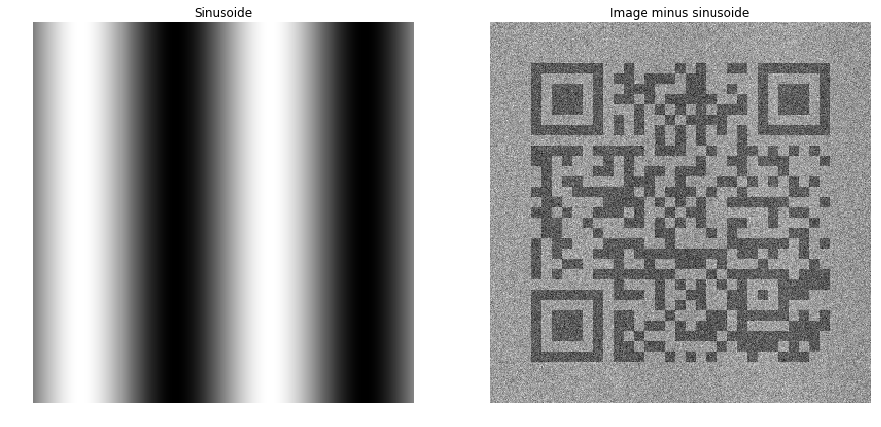

In [7]:
# (3)

# plotting QR image without support sinusoide
show_images(np.repeat([support_sin], N, axis=0), 'Sinusoide', real_img - support_sin, 'Image minus sinusoide', cmap='gray')

(4) Ok, it seems much better now. Try to remove rest of the noise. Use gaussian filter. Play with parameters in order to get better results.

In [8]:
# functions from HW1

def BC_check(boundary):
    
    """
    Checks whether the boundary condition is available
    :param boundary: "zero" or "periodic" (wrap), or "mirror" (default). How to deal with border elements
    """
    
    if boundary not in ['zero', 'periodic', 'wrap', 'mirror']:
        raise Exception('No such boundary condition \'{}\''.format(boundary))
        
def mode_check(mode):
    
    """
    Checks whether the filtering mode is available
    :param mode: "same" (default) or "valid" (valid mode takes into account only native elements of input image)
    """
    
    if mode not in ['same', 'valid']:
        raise Exception('No such mode \'{}\''.format(mode))
        
def image_expanding(image, shape, mode, boundary):
    
    """
    Expands the image depending on the processing window shape, mode and boundary condition
    :param image: input image to be expanded
    :param shape: shape of the processing window of the filter
    :param mode: "same" (default) or "valid" (valid mode takes into account only native elements of input image)
    :param boundary: "zero" or "periodic" (wrap), or "mirror" (default). How to deal with border elements
    """
    
    # shape of the processing window
    M1, M2 = shape
    
    # shift from top and bottom
    shift1 = (M1 - 1) / 2
    # shitf from left and right
    shift2 = (M2 - 1) / 2
    
    # non-symmetric shifts in the case of even-sized kernel
    even1 = 1 - M1 % 2
    even2 = 1 - M2 % 2
    
    # shape of the image
    N1, N2 = image.shape
    
    # if the mode is 'valid', image is imposed to be expanded version of itself; boundary condition is meaningless
    if (mode == 'valid'):
        
        # expanding image in itself (:smile:)
        image_expand = image
    
    # if the mode is 'same', expanded image requires actual expanding
    else:
        
        # shape of the expanded image
        N1, N2 = N1 + 2*shift1 + even1, N2 + 2*shift2 + even2

        # creating the expanded version of the image, which is dependent on the given boundary condition
        # if the boundary condition is mirror, pad new array with reflected elements on calculated shifts
        if (boundary == 'mirror'):
            image_expand = np.pad(image, [(shift1 + even1, shift1), (shift2 + even2, shift2)], 'symmetric')
            
        # if the boundary condition is wrap, pad new array with repeated elements on calculated shifts
        elif (boundary in ['periodic','wrap']):
            image_expand = np.pad(image, [(shift1 + even1, shift1), (shift2 + even2, shift2)], 'wrap')
            
        # if the boundary condition is zero, pad new array with zeros on calculated shifts
        else:
            image_expand = np.pad(image, [(shift1 + even1, shift1), (shift2 + even2, shift2)], 'constant')
            
    return image_expand, (N1, N2)

def convolution_2d(image, kernel, mode='same', boundary='mirror'):
    
    """
    Implementation of the 2D convolution, using direct approach
    :param image: input image X
    :param kernel: filter kernel H
    :param mode: "same" (default) or "valid" (valid mode takes into account only native elements of input image)
    :param boundary: "zero" or "periodic" (wrap), or "mirror" (default). How to deal with border elements
    :return: convolved image Y = X * H
    """
    
    # check out whether the boundary condition is available
    BC_check(boundary)
    
    # check out whether the convolution mode is available
    mode_check(mode)
    
    # flipping kernel by both axes (it's convolution, not correlation :smile:)
    kernel = np.flipud(np.fliplr(kernel))
    # shape of the kernel
    M1, M2 = kernel.shape
    
    # expanding image for given mode and boundary condition
    image_expand, (N1, N2) = image_expanding(image, (M1, M2), mode, boundary)
    
    # array for convolved image (to be filled)
    convolved_im = np.zeros((N1 - M1 + 1, N2 - M2 + 1))
    
    # convolution process, (N-M+1) - amount of convolution elements in row/column
    for i in range(N1 - M1 + 1):
        for j in range(N2 - M2 + 1):
            convolved_im[i, j] = np.sum(image_expand[i:i+M1, j:j+M2] * kernel)
            
    return convolved_im

def gaussian_kernel_1d(sigma, radius):
    
    """
    Implementation of the Gaussian kernel in 1d-array
    :param sigma: standard deviation of the Gaussian distribution
    :param radius: number of points in kernel
    :return: Gaussian kernel (1d-array)
    """
    
    # if radius is not positive integer, raise an exception
    if (type(radius) is not int) or (radius <= 0):
        raise Exception('Invalid radius value {}'.format(radius))
    
    # sigma is negative, raise an exception
    if (sigma < 0):
        raise Exception('Invalid sigma value {}'.format(sigma))
    
    # if sigma is zero, Gaussian distrbution transforms into the Dirac delta-function
    if (sigma == 0):
        
        # if the kernel size is even, delta-function can not be built - raise an exception
        if (radius % 2 == 0):
            raise Exception('Dirac delta can\'t be built on top of the even sized radius')
        
        # if the kernel size is odd
        else:
            
            # construct kernel with zeros and replace central element with '1'
            kernel = np.zeros((1, radius))
            kernel[:, radius/2] = 1.
            
            return kernel
    
    # maximum value on the abscissa (function will be shifted by this value to be symmetrical to 0)
    shift = (radius - 1.) / 2.
    # doubled variance (dispersion)
    disp = 2. * sigma**2.
    # kernel construction
    kernel = np.exp( - ((np.linspace(0, radius - 1, radius) - shift))**2 / disp) / (np.pi * disp)
    # normalizing coefficient (1-norm)
    norm = np.linalg.norm(kernel, 1)
    
    # dividing by the coefficient, if it is required; []-brackets are added to allow kernel to be transposed
    if (norm == 0): 
        return np.array([kernel])
    
    return np.array([kernel / norm])

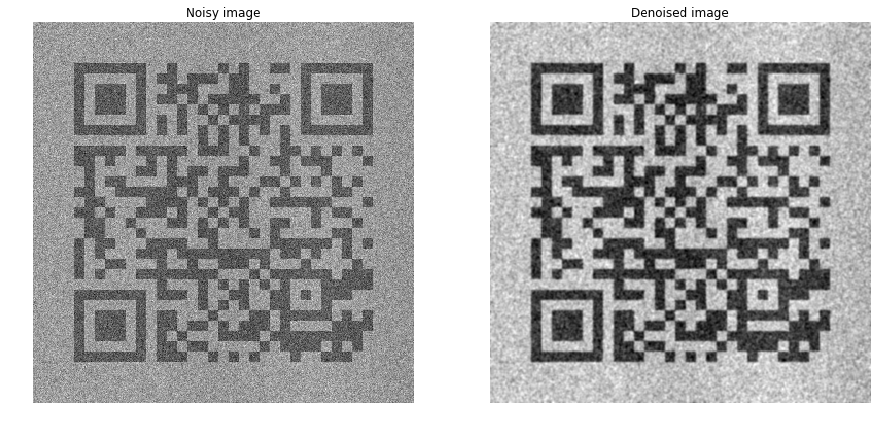

In [9]:
# (4)

# optimal parameters for the Gaussian filter
SIGMA = 0.9
RADIUS = 5

# constructing thr kernel of the Gaussian filter
kern = gaussian_kernel_1d(SIGMA, RADIUS)
# transposed kernel
kern_T = np.transpose(kern)

# QR image without support sinusoide
input_img = real_img - support_sin

# filtering the QR image
denoised_img = convolution_2d(input_img, kern)
denoised_img = convolution_2d(denoised_img, kern_T)

# plotting
show_images(input_img, 'Noisy image', denoised_img, 'Denoised image', cmap='gray')

(5) Make it sharper. Hint: use high-pass filter

In [10]:
# sharpening function from HW1

LAPL_CROSS = np.array([[0., 1., 0.], [1., -4., 1.], [0., 1., 0.]])

def laplace_sharpening(input_img, C, lapl_kern):
    
    """
    Implements image sharpening with Laplace filter enhancements
    :param input_img: input image to be enhanced
    :param C: weight of the structure component
    :param lapl_kern: kernel of the Laplace filter
    :return: sharpened image
    """
    
    # converting to the float (just in case)
    input_img = img_as_float(input_img)
    
    # if the image has 3 layers, convolution is applied to every layer, which implies the need to have cycle
    if (input_img.ndim == 3):
        
        # array for convolved image (to be filled)
        convolved_img = np.zeros_like(input_img, dtype=float)
        
        # run convolutions for each layer of image
        for c in range(3):
            convolved_img[..., c] = convolution_2d(input_img[..., c], lapl_kern)
    
    # in the case of 1 layer image
    else:
        
        # run convolution
        convolved_img = convolution_2d(input_img, lapl_kern)
    
    # weighted sharpening
    sharpened_img = input_img + C * convolved_img
    
    # eliminating artifatcs of values out of the float diapason
    sharpened_img[sharpened_img < 0.] = 0.
    sharpened_img[sharpened_img > 1.] = 1.
    
    return sharpened_img

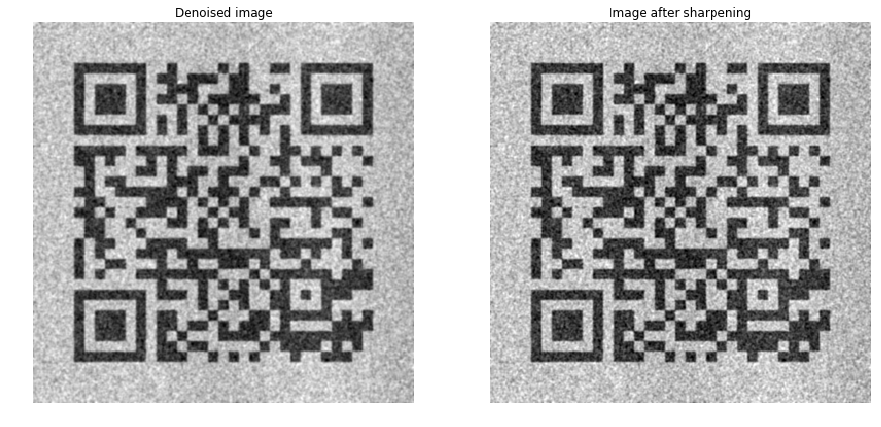

In [11]:
# (5)

# rescaling denoised image to the [0, 1] interval
denoised_img -= np.min(denoised_img)
denoised_img /= np.max(denoised_img)

# optimal blending parameter
C = -0.15

# sharpening
sharpened_img = laplace_sharpening(denoised_img, C, LAPL_CROSS)

# plotting
show_images(denoised_img, 'Denoised image', sharpened_img, 'Image after sharpening', cmap='gray')

(6) Ok, almost done. Use np.round function to get the result. Note that your image at this point should be distributed from 0 to 1.

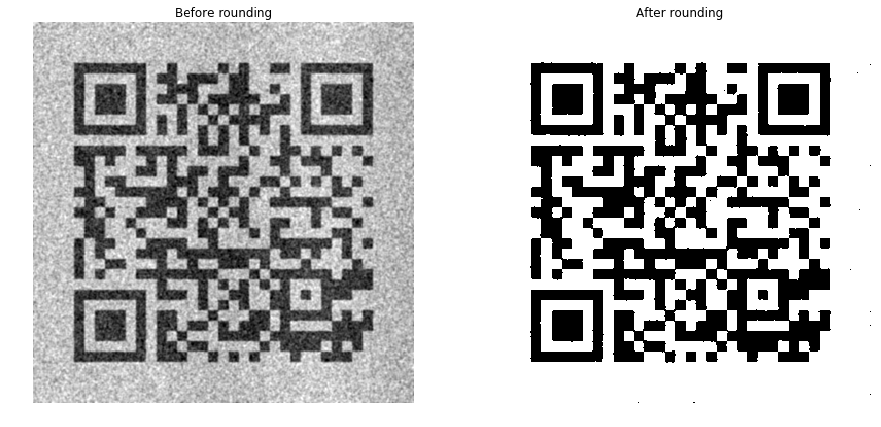

In [12]:
# (6)

# rounding QR image
round_image = np.round(sharpened_img)

# plotting
show_images(sharpened_img, 'Before rounding', round_image, 'After rounding', cmap='gray')

(7) Can your phone read it now?

https://skoltech.instructure.com/courses/1430